In [1]:
import numpy as np
from scipy import special, optimize
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15
pd.options.display.float_format = "{:.4f}".format

In [2]:
def para(w,h,theta):
    a = 1/w
    b = 1/h
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma


def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,alpha,beta,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
    
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand


def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p



def mu(x,y,a,numSteps,thetabg,pdicts):
    """image model for gaussian psf"""
    mu = np.zeros(x.shape)
    for p in pdicts:   
        alpha, beta, gamma = para(p['w'],p['h'],p['theta'])
        K = k(alpha, beta, gamma)
        mu_p = mu_prime(x,y,p['x0'],p['y0'],alpha, beta, gamma,a,numSteps)
        p['mu'] = p["I"]*K*mu_p/alpha/beta
        mu += p['mu']
    return mu + thetabg*a**2


In [3]:
def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d


def dErf(x,y1,y2,gamma):
    """delta error functions for thetaX, thetaY derivatives"""
    deltaErf = special.erf((y1+x*gamma)/np.sqrt(2))-special.erf((y2+x*gamma)/np.sqrt(2)) 
    return deltaErf


def dmu_dthetaX(x,y,a,p):
    """derivative of mu wrt thetaX"""
    alpha, beta, gamma = para(p['w'],p['h'],p['theta'])
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,p['x0'],p['y0'],alpha,beta,a)
    derf_u1 = dErf(u1,v2,v1,gamma)
    derf_u2 = dErf(u2,v2,v1,gamma)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2 - np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1
    dmu_dthetaX = p['I']*K*(-alpha)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaX


def dmu_dthetaY(x,y,a,p):
    """derivative of mu wrt thetaY"""
    alpha, beta, gamma = para(p['w'],p['h'],p['theta'])
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,p['x0'],p['y0'],alpha,beta,a)
    derf_v1 = dErf(v1,u2,u1,gamma)
    derf_v2 = dErf(v2,u2,u1,gamma)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2 - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1
    dmu_dthetaY = p['I']*K*(-beta)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaY



In [4]:
def takeDer(para,x,y,a,pdicts):
    """take derivatives options"""
    for i in range(len(pdicts)):
        if para == "X"+str(i):
            der = dmu_dthetaX(x,y,a,pdicts[i])
        elif para == "Y"+str(i):
            der = dmu_dthetaY(x,y,a,pdicts[i])       
        elif para == "b":
            der = dmu_dthetabg(a)
    return der


def fisher(xmax, ymax, a,numSteps,thetabg, pdicts):
    """calculate fisher matrix"""
    paras=[]
    for i in range(len(pdicts)):
        paras.append('X'+str(i))
        paras.append("Y"+str(i))
    paras.append('b')
    
    n = len(paras)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    mus= mu(xs,ys,a,numSteps,thetabg,pdicts)

    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(paras[i],xs,ys,a,pdicts) * \
                                 takeDer(paras[j],xs,ys,a,pdicts))
    return fisher


def crlb(xmax, ymax, a,numSteps,thetabg, pdicts):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, a,numSteps,thetabg, pdicts)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs


# photons expected: 100.000
# photons code    : 96.045
#

[0.2146986683766801,
 0.21469866837668006,
 0.2250460142186846,
 0.22504601421868461,
 0.26322855611424634,
 0.26322855611424634,
 0.25610086355982487,
 0.2314013417376906,
 0.23140134173769064,
 0.2561008635598248,
 0.004332626910370185]

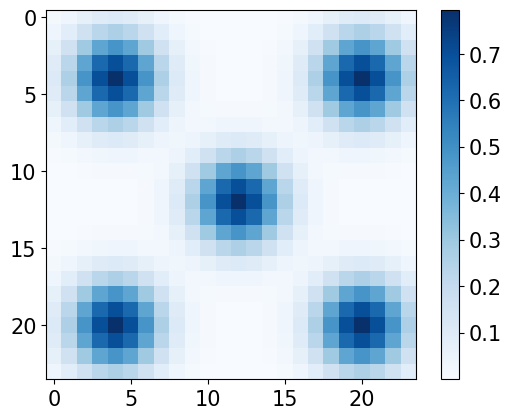

In [5]:
# feed in dictionary of parameters for particles x0, y0, width, height, angle, intensity
xmax = 3*8
ymax = xmax
xi = xmax/2
yi = xi
sep = 8
w = 2
h = 2
theta = 0
I = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

p0 = {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I }
p1 = {'x0':xi-sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I}
p2 = {'x0':xi+sep , 'y0':yi+sep, 'w':w , 'h':h , 'theta':theta , 'I':I}
p3 = {'x0':xi+sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
p4 = {'x0':xi-sep , 'y0':yi+sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
# separate para for code: bg, a, numsteps
pdicts = [p0,p1,p2,p3,p4]

a = 0.2
thetabg = 1e-5
numSteps = 30

im = mu(xs,ys,a,numSteps,thetabg,pdicts)
plt.imshow(im,cmap="Blues")
plt.colorbar()


print(f'# photons expected: {a**2*thetabg*xmax**2+I*a**2*5:.3f}')
print(f'# photons code    : {np.sum(im):.3f}')
crlb(xmax, ymax, a,numSteps,thetabg, pdicts)

# photons expected: 100.000
# photons code    : 100.000


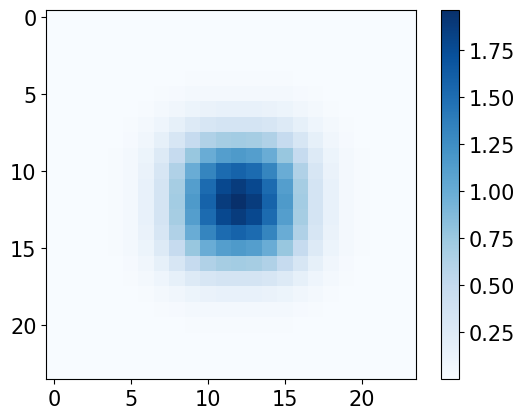

In [6]:
# feed in dictionary of parameters for particles x0, y0, width, height, angle, intensity
xmax = 3*8
ymax = xmax
xi = xmax/2
yi = xi
sep = 2
w = 2
h = 2
theta = 0
I = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

p0 = {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I }
p1 = {'x0':xi-sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I}
p2 = {'x0':xi+sep , 'y0':yi+sep, 'w':w , 'h':h , 'theta':theta , 'I':I}
p3 = {'x0':xi+sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
p4 = {'x0':xi-sep , 'y0':yi+sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
# separate para for code: bg, a, numsteps
pdicts = [p0,p1,p2,p3,p4]

a = 0.2
thetabg = 1e-5
numSteps = 30

im = mu(xs,ys,a,numSteps,thetabg,pdicts)
plt.imshow(im,cmap="Blues")
plt.colorbar()

print(f'# photons expected: {a**2*thetabg*xmax**2+I*a**2*5:.3f}')
print(f'# photons code    : {np.sum(im):.3f}')

In [7]:
# feed in dictionary of parameters for particles x0, y0, width, height, angle, intensity
xmax = 3*8
ymax = xmax
xi = xmax/2
yi = xi
w = 2
h = 2
theta = 0
I = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

a = 0.2
thetabg = 1e-5
numSteps = 30

seps = np.linspace(0.5,7,20)

crlbs = []

for sep in seps:
    p0 = {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I }
    p1 = {'x0':xi-sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I}
    p2 = {'x0':xi+sep , 'y0':yi+sep, 'w':w , 'h':h , 'theta':theta , 'I':I}
    p3 = {'x0':xi+sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
    p4 = {'x0':xi-sep , 'y0':yi+sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
    # separate para for code: bg, a, numsteps
    pdicts = [p0,p1,p2,p3,p4]
    crlbs.append(crlb(xmax, ymax, a,numSteps,thetabg, pdicts))
    

####################

In [8]:
varR = [crlbs[i][0]+crlbs[i][1] for i in range(len(crlbs))]

In [9]:
def correct(fisherM, pdicts, thetabg):
    F = np.zeros(fisherM.shape)
    fisherInv = np.linalg.inv(fisherM)
    
    paraVal=[]
    for i in range(len(pdicts)):
        paraVal.append(pdicts[i]['x0'])
        paraVal.append(pdicts[i]['y0'])
    paraVal.append(thetabg)

    for i in range(len(fisherM)):
        for j in range(len(fisherM)):
            A = (paraVal[i] - paraVal[j])**2/(np.sqrt(fisherInv[i,i])*np.sqrt(fisherInv[j,j]))
            if (i%2 == 0 and j%2 == 0 and i!=j) or (i%2 != 0 and j%2 != 0 and i!=len(fisherM) and j!=len(fisherM) and i!=j):
                F[i,j] = A/(A+1)*fisherM[i,j]
            else:
                F[i,j] = fisherM[i,j]
    Finv = np.linalg.inv(F)
    return F, Finv

def crlbC(xmax, ymax, a,numSteps,thetabg, pdicts):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, a,numSteps,thetabg, pdicts)
    _, fisherInv = correct(fisherM, pdicts, thetabg)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs

In [10]:
# feed in dictionary of parameters for particles x0, y0, width, height, angle, intensity
xmax = 3*8
ymax = xmax
xi = xmax/2
yi = xi
w = 2
h = 2
theta = 0
I = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

a = 0.2
thetabg = 1e-5
numSteps = 30

seps = np.linspace(0.5,8.5,20)

crlbsC = []

for sep in seps:
    p0 = {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I }
    p1 = {'x0':xi-sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I}
    p2 = {'x0':xi+sep , 'y0':yi+sep, 'w':w , 'h':h , 'theta':theta , 'I':I}
    p3 = {'x0':xi+sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
    p4 = {'x0':xi-sep , 'y0':yi+sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
    # separate para for code: bg, a, numsteps
    pdicts = [p0,p1,p2,p3,p4]
    crlbsC.append(crlbC(xmax, ymax, a,numSteps,thetabg, pdicts))
    
varRC = [crlbsC[i][0]+crlbsC[i][1] for i in range(len(crlbsC))]


####################

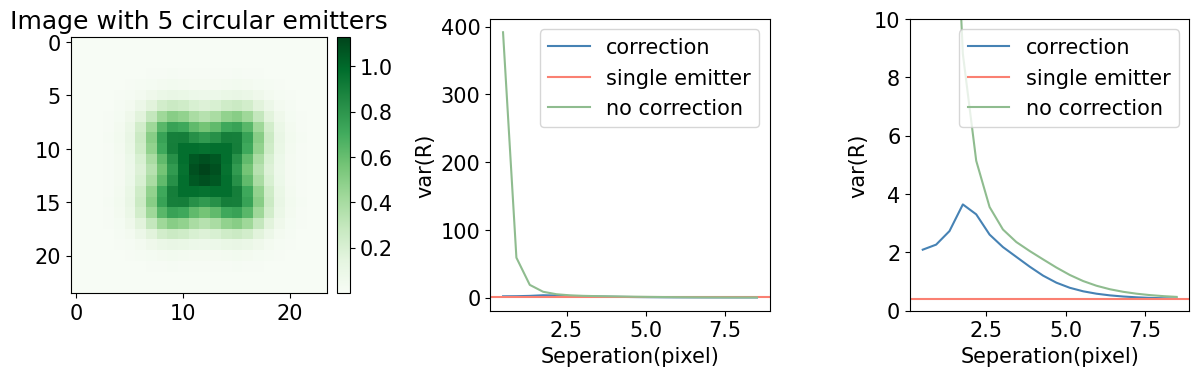

In [23]:
xmax = 3*8
ymax = xmax
xi = xmax/2
yi = xi
sep = 3
w = 2
h = 2
theta = 0
I = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

p0 = {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I }
p1 = {'x0':xi-sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I}
p2 = {'x0':xi+sep , 'y0':yi+sep, 'w':w , 'h':h , 'theta':theta , 'I':I}
p3 = {'x0':xi+sep , 'y0':yi-sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
p4 = {'x0':xi-sep , 'y0':yi+sep , 'w':w , 'h':h , 'theta':theta , 'I':I }
# separate para for code: bg, a, numsteps
pdicts = [p0,p1,p2,p3,p4]

a = 0.2
thetabg = 1e-5
numSteps = 30

im = mu(xs,ys,a,numSteps,thetabg,pdicts)


fig, ax = plt.subplots(1,3,figsize=(12,4))
im = ax[0].imshow(im,cmap="Greens")
ax[0].set_title("Image with 5 circular emitters")
div0 = make_axes_locatable(ax[0])
cax0 = div0.append_axes("right", size="5%", pad=0.1)
cbr0 = plt.colorbar(im, cax=cax0, orientation="vertical")

for i in range(1,3):
    ax[i].plot(seps, varRC,c="steelblue",label="correction")
    ax[i].axhline(y = 0.40034,c="salmon",label="single emitter")
    ax[i].plot(seps, varR,c="darkseagreen",label="no correction")
    ax[i].set_xlabel("Seperation(pixel)")
    ax[i].set_ylabel("var(R)")
    ax[i].legend()
    
ax[2].set_ylim((0,10))
fig.tight_layout();

# huang 2011
- frame 256x256 px, px size 0.106 mu-m
- 2d gaussian, randomly placed with uniform distribution
- sigma psf = 1.2 px = 127 nm
- expected intensity drawn from N(800, sigma=10)
- Background count rate 5 count/pixel. corrupted with poisson noise.

## simulate
- 2 emitters, increasing separations. for each separation, generate 1000 identical 2 emitter images, corrupted by poisson noise and fit
- images of 1000 configurations of random placements of 1-5 emitters replicated 1000 times, corrupted by poisson noise and fit



In [54]:
# feed in dictionary of parameters for particles x0, y0, width, height, angle, intensity
xmax = 256*106e-9
ymax = xmax
w = 127e-9
h = w
#not rotated
theta = 0
# intesity from normal distribution
x,y = np.linspace(0,xmax,num=256), np.linspace(0,xmax,num=256)
xs, ys = np.meshgrid(x,y)
a = 106e-9
thetabg = 5
numSteps = 30

In [55]:
pdicts=[]
for i in range(20):
    I = np.random.normal(loc=800, scale=10)
    # position random normal
    xi = np.random.normal(256//2,10)*1e-9
    yi = np.random.normal(256//2,10)*1e-9
    pdicts.append( {'x0':xi, 'y0':yi, 'w':w , 'h':h , 'theta':theta , 'I':I })
    
pdicts

[{'x0': 1.236562921874103e-07,
  'y0': 1.252419543258856e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 799.9356498674958},
 {'x0': 1.3077951824042592e-07,
  'y0': 1.1952604881771864e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 803.2462744180195},
 {'x0': 1.264456704548676e-07,
  'y0': 1.3251597746788413e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 794.0352932033513},
 {'x0': 1.3161483038282805e-07,
  'y0': 1.44315543595829e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 815.8281958675567},
 {'x0': 1.2685796548347753e-07,
  'y0': 1.2379126387937717e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 796.5942815343197},
 {'x0': 1.2941849123296925e-07,
  'y0': 1.3087934243506636e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 819.4713621775745},
 {'x0': 1.2638315228933507e-07,
  'y0': 1.0401662922377042e-07,
  'w': 1.27e-07,
  'h': 1.27e-07,
  'theta': 0,
  'I': 798.515450174434},
 {'x0': 1.1644407368974933e-07,
 

(array([ 4., 11., 19., 42., 59., 58., 53., 29., 16.,  9.]),
 array([9.83957969e-08, 1.03823154e-07, 1.09250511e-07, 1.14677868e-07,
        1.20105226e-07, 1.25532583e-07, 1.30959940e-07, 1.36387297e-07,
        1.41814655e-07, 1.47242012e-07, 1.52669369e-07]),
 <BarContainer object of 10 artists>)

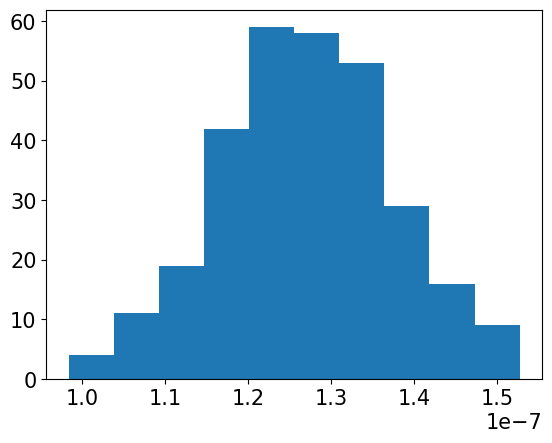

In [67]:
plt.hist([np.random.normal(256//2,10)*1e-9 for i in range(300)])

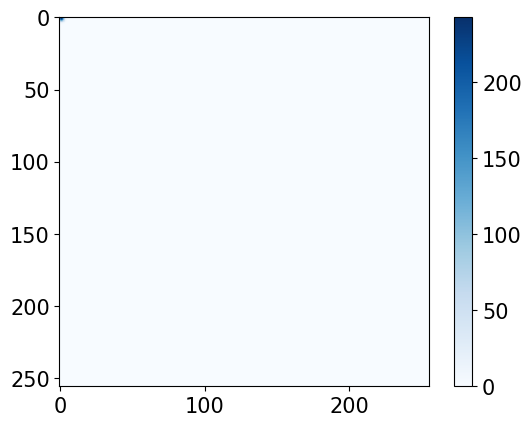

In [58]:
im = mu(xs,ys,a,numSteps,thetabg,pdicts[1:4])
plt.imshow(im,cmap="Blues")
plt.colorbar()

(0.0, 10.0)

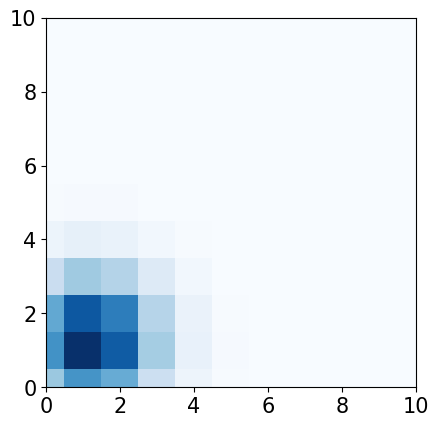

In [66]:
plt.imshow(im,cmap="Blues")
prange=(0,10)
plt.xlim(prange)
plt.ylim(prange)

In [68]:
im

array([[9.27077535e+01, 1.49156169e+02, 1.23748248e+02, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14],
       [1.51119946e+02, 2.43141195e+02, 2.01745495e+02, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14],
       [1.27503834e+02, 2.05173999e+02, 1.70260351e+02, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14],
       ...,
       [5.61800000e-14, 5.61800000e-14, 5.61800000e-14, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14],
       [5.61800000e-14, 5.61800000e-14, 5.61800000e-14, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14],
       [5.61800000e-14, 5.61800000e-14, 5.61800000e-14, ...,
        5.61800000e-14, 5.61800000e-14, 5.61800000e-14]])